The motivation of this blog post is to provide a intuition and a practical guide to train a (simple) diffusion model together with the respective code leveraging PyTorch. If you are interested in a more mathematical description with proofs I can highly recommend TODO: Citation: Understanding Diffusion Models: A Unified Perspective

In general, the goal of a diffusion model is to be able to generate novel data after being trained on data points of that distribution.

Here, let's consider a simple 2D toy dataset provided by scikit-learn to make this example as simple as possible: the"Two Moons" dataset shown in [Figure].

In [1]:
from typing import Tuple

import torch
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from torch import nn
from tqdm import trange
import seaborn as sns

sns.set()
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.0)

In [2]:
BOUNDS = (-1.5, 1.5)


def plot_vectorfield(model: nn.Module, t: int = 1, ax: plt.Axes = None):
    if ax is None:
        _, ax = plt.subplots()

    coords = torch.cartesian_prod(
        torch.linspace(*BOUNDS, 15), torch.linspace(*BOUNDS, 15)
    )

    with torch.no_grad():
        out = model(
            coords, t=torch.full(size=(len(coords),), fill_value=t, dtype=torch.long)
        )

    out = out.cpu().numpy()
    coords = coords.cpu().numpy()
    ax.quiver(coords[:, 0], coords[:, 1], -out[:, 0], -out[:, 1], angles="xy")
    return ax


def plot_samples(samples, ax=None):
    if not ax:
        _, ax = plt.subplots()
    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], ax=ax)
    ax.set(xlim=BOUNDS, ylim=BOUNDS, aspect="equal")


def plot_kde(samples, ax=None):
    if not ax:
        _, ax = plt.subplots()
    ax.set(xlim=BOUNDS, ylim=BOUNDS, aspect="equal")
    sns.kdeplot(
        x=samples[:, 0],
        y=samples[:, 1],
        ax=ax,
        fill=True,
        thresh=0.0,
        cut=15.0,
        clip=(-3, 3),
        bw_adjust=0.5,
    )

In [3]:
X, y = make_moons(n_samples=1_000)

X = torch.Tensor(X)
y = torch.LongTensor(y)

# Ho et al, 2020: Linear scaling for inputs into [-1, 1]
X -= X.min(dim=0, keepdim=True)[0]
X /= X.max(dim=0, keepdim=True)[0]
X = X * 2 - 1
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

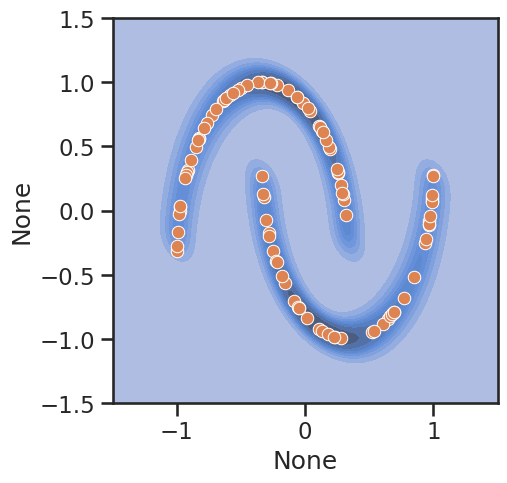

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_kde(X, ax=ax)
plot_samples(X[:100], ax=ax)

Diffusion models define a forward and backward process:

* the forward process gradually adds noise to the data until the original data is indistinguishable (one arrives at a standard normal distribution $N(0, \mathbf{I})$)
* the backward process aims to reverse the forward process, i.e., start from noise and then gradually try to restore data 

One aims to learn the backward process, so one can generate new samples by starting from random noise.
 

To be able to start training a model that learns this backward process, we need to know how to do the forward process one aims to reverse.

The Gaussian noise one adds at every step $t$ is controlled by parameters $\beta_t$ that increases as $t \rightarrow T$ so we get random Gaussian noise in the end:
$$
\begin{equation}
q(x_t \mid x_{t-1}) \sim \mathcal{N}(\sqrt{1 - \beta_t}x_{t-1}, \beta_t \mathbf{I})
\end{equation}
$$

So one can start from our original data samples $x_0$ and then gradually add noise to the sample.

The cool thing about this being Gaussian noise is that instead of simulating this forward process by iteratively sampling noise, one can derive a closed form for the distribution at a certain $t$ given the original datapoint $x_0$ so one has to only sample noise once:
$$
\begin{equation}
q(x_t \mid x_0) \sim \mathcal{N}(\sqrt{\bar{\alpha}}_t x_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{equation}
$$
with $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$.


Let's implement this:

In [5]:
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas

        self.alphas = 1.0 - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=-1)

    def get_x_t(
        self, x_0: torch.Tensor, t: torch.LongTensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process given the unperturbed sample x_0.

        Args:
            x_0: Original, unperturbed samples.
            t: Target timestamp of the diffusion process of each sample.

        Returns:
            Noise added to original sample and perturbed sample.
        """
        eps_0 = torch.randn_like(x_0).to(x_0)
        alpha_bar = self.alpha_bar[t, None]
        mean = (alpha_bar**0.5) * x_0
        std = (1.0 - alpha_bar) ** 0.5

        return (eps_0, mean + std * eps_0)

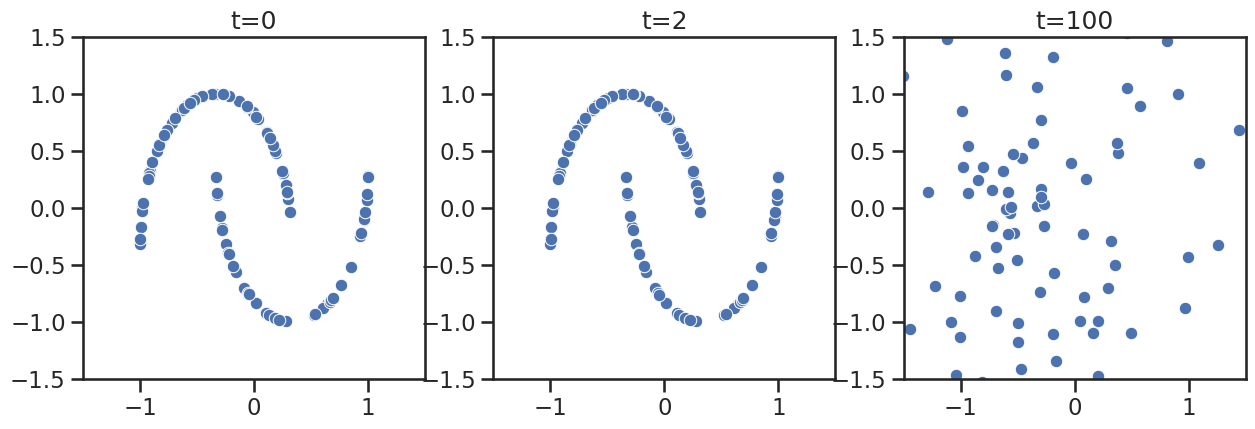

In [131]:
T = 100  # Number of diffusion steps
betas = torch.linspace(0.0, 0.99, T + 1) ** 4
fp = ForwardProcess(betas=betas)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x_t = X[:100].clone()  # Start with some of the original data
for idx, t in enumerate([0, 2, T]):
    x_t = fp.get_x_t(X[:100], t=torch.LongTensor([t]))[1].numpy()
    sns.scatterplot(x=x_t[:, 0], y=x_t[:, 1], ax=ax[idx])
    ax[idx].set(xlim=BOUNDS, ylim=BOUNDS, title=f"t={t}", aspect="equal")

### Training
Next, we want to train a model that reverses that process.

For this, one can show that the there is also a closed form for the less noisy version $x_{t-1}$ given the next sample $x_t$ and the original sample $x_0$.
$$
\begin{equation}
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(\mu(x_t, x_0), \sigma_t^2\mathbf{I})
\end{equation}
$$
where 
$$
\begin{equation}
\sigma_t^2 = \frac{(1 - \alpha_t)(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}, \quad \mu(x_t, x_0) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_0\right)
\end{equation}
$$
and $\epsilon_0 \sim \mathcal{N}(0, \mathbf{I})$ is the noise drawn to perturb the original data $x_0$. 

Obviously, we cannot use this directly to generate new data since this relies on knowing the original datapoint $x_0$ in the first place but **we can use it to generate the ground truth data for training a model that does not rely on $\mathbf{x}_0$ and predicts $\epsilon_0$ from the noisy data $\mathbf{x}_t$ and $t$ alone**.

Let's define a small neural network $\epsilon_{\mathbf{\theta}}(\mathbf{x}_t, t)$ where $\mathbf{\theta}$ are the parameters of the network that does just that:

In [ ]:
class NoisePredictor(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.t_encoder = nn.Linear(T, 1)

        self.t_encoder = nn.Embedding(num_embeddings=T + 1, embedding_dim=32)
        self.x_encoder = nn.Linear(2, 32)

        self.model = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(inplace=True),
            nn.Linear(16, 16),
            nn.LeakyReLU(inplace=True),
            nn.Linear(16, 16),
            nn.LeakyReLU(inplace=True),
            nn.Linear(16, 16),
            nn.LeakyReLU(inplace=True),
            nn.Linear(16, 2),
        )

    def forward(self, x_t, t):
        # Encode the time index t as one-hot and then use one layer to encode
        # into a single value
        te = self.t_encoder(t)
        xe = self.x_encoder(x_t)

        return self.model(te + xe)

Here, we encode the timestamp of the diffusion process $t$ as a one-hot vector with a single layer and then concatenate this information with the noisy data.

**Next up**: Training the model to predict the noise. 
For this, one can just sample $t$'s, use the forward process to generate the noisy sample $x_t$ together with the noise $e_0$, and train the model to reduce the mean squared error between the predicted noise and $e_0$.

In [ ]:
model = NoisePredictor(T=T)
optimizer = torch.optim.AdamW(
    params=model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=1e-4
)

N = X.shape[0]
for epoch in trange(10_000):
    with torch.no_grad():
        # Sample random t's
        t = torch.randint(low=1, high=T + 1, size=(N,))

        # Get the noise added and the noisy version of the data using the forward
        # process given t
        eps_0, x_t = fp.get_x_t(X, t=t)

    # Predict the noise added to x_0 from x_t
    pred_eps = model(x_t, t)

    # Simplified objective without weighting with alpha terms (Ho et al, 2020)
    loss = torch.nn.functional.mse_loss(pred_eps, eps_0)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 500 == 0:
        print(f"{epoch=}, loss={loss.item()}")

  0%|          | 47/10000 [00:00<00:42, 236.76it/s]

epoch=0, loss=1.0812941789627075


  6%|▌         | 552/10000 [00:02<00:38, 244.25it/s]

epoch=500, loss=0.4070391356945038


 10%|█         | 1034/10000 [00:04<00:34, 263.22it/s]

epoch=1000, loss=0.3010959029197693


 15%|█▌        | 1546/10000 [00:06<00:32, 263.07it/s]

epoch=1500, loss=0.37965908646583557


 20%|██        | 2031/10000 [00:07<00:30, 263.71it/s]

epoch=2000, loss=0.33555474877357483


 25%|██▌       | 2544/10000 [00:09<00:28, 264.02it/s]

epoch=2500, loss=0.36096319556236267


 30%|███       | 3030/10000 [00:11<00:26, 265.53it/s]

epoch=3000, loss=0.3305259048938751


 35%|███▌      | 3543/10000 [00:13<00:24, 266.35it/s]

epoch=3500, loss=0.33517009019851685


 40%|████      | 4028/10000 [00:15<00:22, 264.93it/s]

epoch=4000, loss=0.36120840907096863


 45%|████▌     | 4539/10000 [00:17<00:20, 264.43it/s]

epoch=4500, loss=0.35930386185646057


 51%|█████     | 5052/10000 [00:19<00:18, 264.05it/s]

epoch=5000, loss=0.3777232766151428


 55%|█████▌    | 5537/10000 [00:21<00:16, 265.81it/s]

epoch=5500, loss=0.32640111446380615


 60%|██████    | 6050/10000 [00:23<00:14, 266.02it/s]

epoch=6000, loss=0.33704155683517456


 65%|██████▌   | 6535/10000 [00:25<00:13, 264.96it/s]

epoch=6500, loss=0.3143766522407532


 70%|███████   | 7048/10000 [00:27<00:11, 263.14it/s]

epoch=7000, loss=0.32584455609321594


 75%|███████▌  | 7533/10000 [00:28<00:09, 266.32it/s]

epoch=7500, loss=0.30671387910842896


 80%|████████  | 8046/10000 [00:30<00:07, 264.50it/s]

epoch=8000, loss=0.3269413113594055


 85%|████████▌ | 8531/10000 [00:32<00:05, 264.61it/s]

epoch=8500, loss=0.34719017148017883


 90%|█████████ | 9044/10000 [00:34<00:03, 263.30it/s]

epoch=9000, loss=0.3175944983959198


 95%|█████████▌| 9528/10000 [00:36<00:01, 263.83it/s]

epoch=9500, loss=0.32209575176239014


100%|██████████| 10000/10000 [00:38<00:00, 260.63it/s]


### Inference
After training the model to predict the noise, we can simply iteratively run the reverse process to predict $x_{t-1}$ from $x_t$ starting from random noise $x_T$ as defined in Eq. TODO where we replace $e_1$ with the model output.

In [ ]:
class ReverseProcess(ForwardProcess):
    def __init__(self, betas: torch.Tensor, model: nn.Module):
        super().__init__(betas)
        self.model = model
        self.T = len(betas) - 1

        self.sigma = (
            (1 - self.alphas)
            * (1 - torch.roll(self.alpha_bar, 1))
            / (1 - self.alpha_bar)
        ) ** 0.5
        self.sigma[1] = 0.0

    def get_x_t_minus_one(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        with torch.no_grad():
            t_vector = torch.full(size=(len(x_t),), fill_value=t, dtype=torch.long)
            eps = self.model(x_t, t=t_vector)

        eps *= (1 - self.alphas[t]) / ((1 - self.alpha_bar[t]) ** 0.5)
        mean = 1 / (self.alphas[t] ** 0.5) * (x_t - eps)
        return mean + self.sigma[t] * torch.randn_like(x_t)

    def sample(self, n_samples=1, full_trajectory=False):
        # Initialize with X_T ~ N(0, I)
        x_t = torch.randn(n_samples, 2)
        trajectory = [x_t.clone()]

        for t in range(self.T, 0, -1):
            x_t = self.get_x_t_minus_one(x_t, t=t)

            if full_trajectory:
                trajectory.append(x_t.clone())
        return torch.stack(trajectory, dim=0) if full_trajectory else x_t

Now, let's sample new data points and plot them:

In [135]:
rp = ReverseProcess(betas=betas, model=model)
samples = rp.sample(n_samples=1_000, full_trajectory=True).cpu().numpy()

In [136]:
import numpy as np

np.any(np.isnan(samples), axis=(1, 2)).argmax()

100

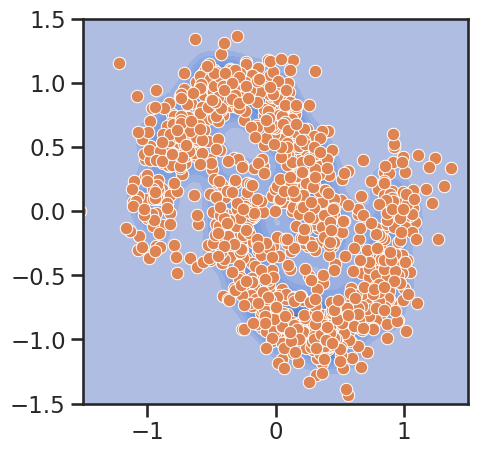

In [145]:
n = -25
fig, ax = plt.subplots(figsize=(5, 5))
plot_kde(samples[n], ax=ax)
plot_samples(samples[n, :1000], ax=ax)

We can also inspect the (negative) direction of the predicted noise vector at a particular timestamp $t$ for each position in a grid to visualize the dynamics a sample follows during the reverse process as a vector field:

[Text(0.5, 1.0, '$- \\epsilon_{\\mathbf{\\theta}}(\\mathbf{x}_t, t=T)$')]

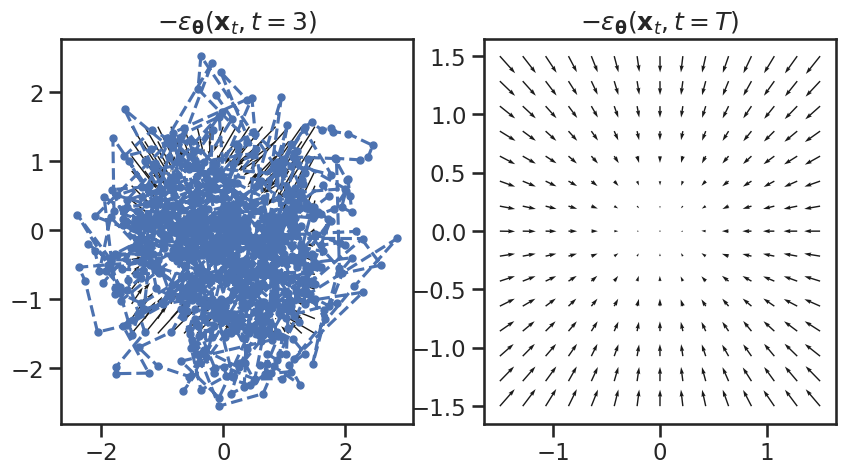

In [213]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_vectorfield(model, t=3, ax=ax[0])
plot_vectorfield(model, t=T, ax=ax[1])

out = rp.sample(n_samples=2, full_trajectory=True).cpu().numpy()[:900]
ax[0].plot(out[:, 0, 0], out[:, 0, 1], "--bo", markersize=5)
ax[0].set(title=r"$- \epsilon_{\mathbf{\theta}}(\mathbf{x}_t, t=3)$")
ax[1].set(title=r"$- \epsilon_{\mathbf{\theta}}(\mathbf{x}_t, t=T)$")

One can see that as $t \rightarrow 0$ more fine-grained structure emerges that guides the sample to the original data manifold. At $t=T$ there the (pure) noise is just guided towards the center as the signal is still very low for the network to predict.

## Insights

Working on this small dataset already revealed some important things that one has to consider when training diffusion models.
In particular, in the beginning when I started to implement this from the paper description, a huge amount of diffusion steps ($T=1000$) were required to yield good results.

Further looking into the literature and appendix of the papers revealed some things that brought down the diffusion steps required to $T=10$:
* It is important to perform linear scaling of the input data into the range $[-1, 1]$. Standardizing the input data (i.e., subtracting the mean and dividing by the standard dev.) as it is usually done for neural networks yielded worse results
* The Variance schedule (${\beta_t}_t$) ideally has small changes towards $t=0$ such that the noise is not too much for the network to reconstruct, i.e., it learn fine-grained details of the data. This was already discovered in TODO: Improved diffusion training. Figure TODO shows how the variance of the forward process $1 - \bar{\alpha}_t$ evolves for when $\beta_t$ is set linear (left), or polynomial (right). The right setting works much better in practice since the perturbation of the input does not happen too fast.

[Text(0.5, 0, 't')]

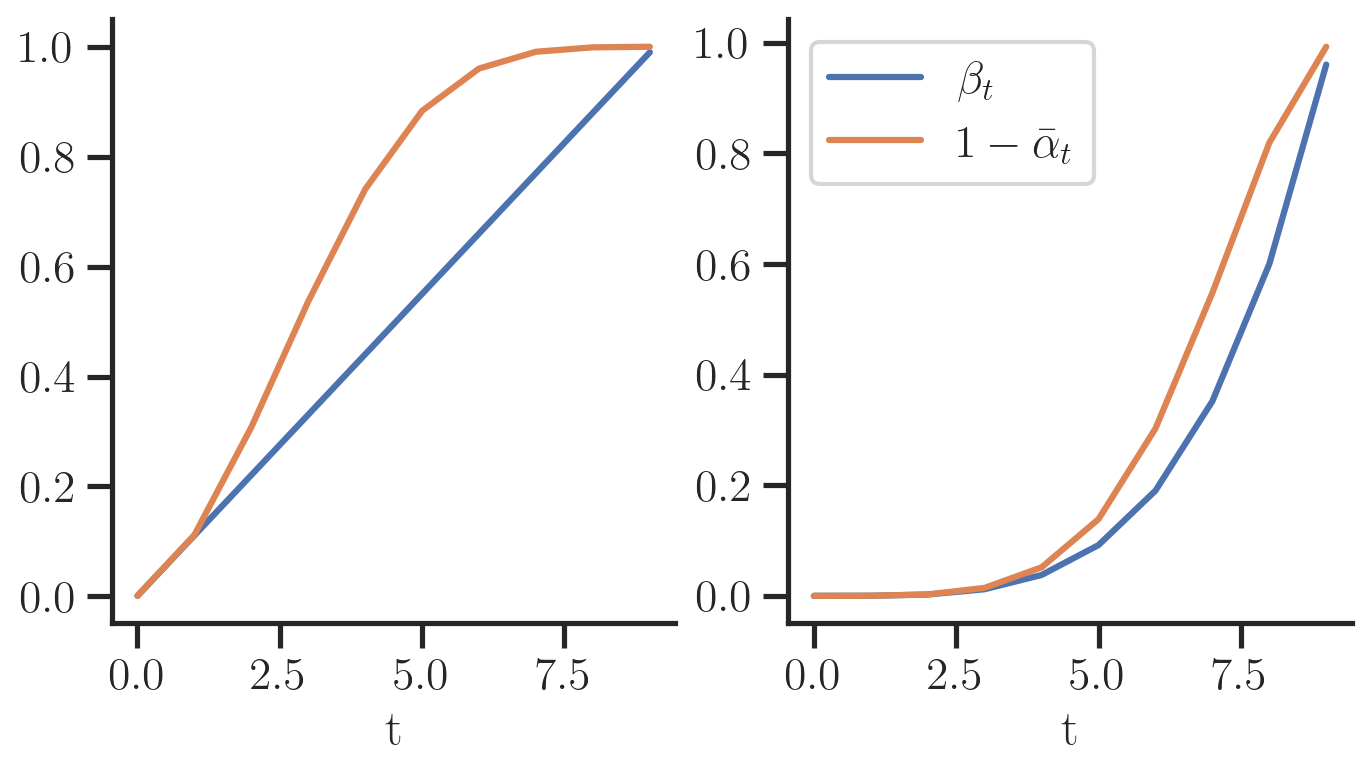

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

betas = torch.linspace(10e-4, 0.99, T)
fp = ForwardProcess(betas=betas)
ax[0].plot(betas, label=r"$\beta_t$")
ax[0].plot(1 - fp.alpha_bar, label=r"$1 - \bar{\alpha}_t$")

betas = torch.linspace(10e-4, 0.99, T) ** 4
fp = ForwardProcess(betas=betas)
ax[1].plot(betas, label=r"$\beta_t$")
ax[1].plot(1 - fp.alpha_bar, label=r"$1 - \bar{\alpha}_t$")
ax[1].legend()

ax[0].set(xlabel="t")
ax[1].set(xlabel="t")

# MNIST

In [24]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the training and test datasets
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data = datasets.MNIST("data", train=False, download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

X = train_data.data.flatten(-2, -1).float()
X.shape

torch.Size([60000, 784])

In [25]:
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas

        self.alphas = 1.0 - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=-1)

    def get_x_t(
        self, x_0: torch.Tensor, t: torch.LongTensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process given the unperturbed sample x_0.

        Args:
            x_0: Original, unperturbed samples.
            t: Target timestamp of the diffusion process of each sample.

        Returns:
            Noise added to original sample and perturbed sample.
        """
        eps_0 = torch.randn_like(x_0).to(x_0)
        alpha_bar = self.alpha_bar[t, None]
        mean = (alpha_bar**0.5) * x_0
        std = (1.0 - alpha_bar) ** 0.5

        return (eps_0, mean + std * eps_0)

In [34]:
class NoisePredictor(nn.Module):
    def __init__(self, T: int, d_input: int = 784, d_hidden: int = 128):
        super().__init__()
        self.T = T
        self.t_encoder = nn.Embedding(num_embeddings=T + 1, embedding_dim=d_hidden)
        self.x_encoder = nn.Linear(d_input, d_hidden)

        self.model = nn.Sequential(
            nn.Linear(d_hidden, d_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(d_hidden, d_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(d_hidden, d_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(d_hidden, d_input),
        )

    def forward(self, x_t, t):
        # Encode the time index t as one-hot and then use one layer to encode
        # into a single value
        te = self.t_encoder(t)
        xe = self.x_encoder(x_t)

        return self.model(te + xe)

In [37]:
T = 100
betas = torch.linspace(10e-4, 0.99, T + 1)
fp = ForwardProcess(betas=betas)

In [38]:
model = NoisePredictor(T=T)
optimizer = torch.optim.AdamW(
    params=model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=1e-4
)

N = X.shape[0]
for epoch in trange(100):
    with torch.no_grad():
        # Sample random t's
        t = torch.randint(low=1, high=T + 1, size=(N,))

        # Get the noise added and the noisy version of the data using the forward
        # process given t
        eps_0, x_t = fp.get_x_t(X, t=t)

    # Predict the noise added to x_0 from x_t
    pred_eps = model(x_t, t)

    # Simplified objective without weighting with alpha terms (Ho et al, 2020)
    loss = torch.nn.functional.mse_loss(pred_eps, eps_0)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 10 == 0:
        print(f"{epoch=}, loss={loss.item()}")

  1%|          | 1/100 [00:01<02:46,  1.68s/it]

epoch=0, loss=1.4514492750167847


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


In [41]:
class ReverseProcess(ForwardProcess):
    def __init__(self, betas: torch.Tensor, model: nn.Module):
        super().__init__(betas)
        self.model = model
        self.T = len(betas) - 1

        self.sigma = (
            (1 - self.alphas)
            * (1 - torch.roll(self.alpha_bar, 1))
            / (1 - self.alpha_bar)
        ) ** 0.5
        self.sigma[1] = 0.0

    def get_x_t_minus_one(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        with torch.no_grad():
            t_vector = torch.full(size=(len(x_t),), fill_value=t, dtype=torch.long)
            eps = self.model(x_t, t=t_vector)

        eps *= (1 - self.alphas[t]) / ((1 - self.alpha_bar[t]) ** 0.5)
        mean = 1 / (self.alphas[t] ** 0.5) * (x_t - eps)
        return mean + self.sigma[t] * torch.randn_like(x_t)

    def sample(self, n_samples=1, full_trajectory=False):
        # Initialize with X_T ~ N(0, I)
        x_t = torch.randn(n_samples, 784)
        trajectory = [x_t.clone()]

        for t in range(self.T, 0, -1):
            x_t = self.get_x_t_minus_one(x_t, t=t)

            if full_trajectory:
                trajectory.append(x_t.clone())
        return torch.stack(trajectory, dim=0) if full_trajectory else x_t

In [50]:
rp = ReverseProcess(betas=betas, model=model)
samples = rp.sample(n_samples=1_000, full_trajectory=True).cpu().numpy()
samples = samples.reshape((*samples.shape[:2], 28, 28))

In [51]:
samples.shape

(101, 1000, 28, 28)

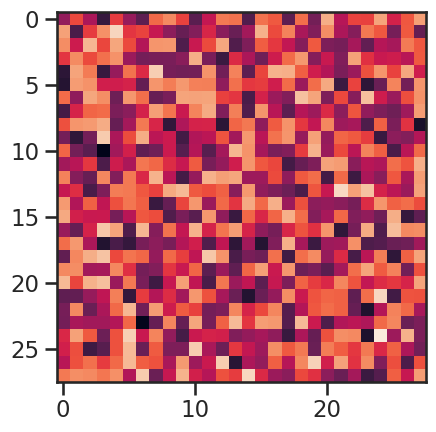

In [62]:
plt.imshow(samples[-1, 5, ...])